<div dir='rtl' id="intro"><h2 id="clustering">تحلیل داده با استفاده از KMeans + WOB  </h2><hr></div>
<br>
<div dir='rtl'>
ابتدا کتابخانه هایی که قرار است در آینده نیازمان شود را ایمپورت میکنیم...

In [1]:
# some libraries that may be needed
import re
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from __future__ import unicode_literals
from hazm import *

<div dir='rtl'>
مثل همیشه مواقع، ابتدا دیتاست را لود میکنیم و یک نگاه اولیه به آن می اندازیم:

In [2]:
original_df = pd.read_csv("random_sample_astan.csv")
original_df

,Unnamed: 0,متن پيام,پاسخ,تاريخ دريافت,زمان دريافت
0,356159,سلام ایا به اشتراک گذاشتن نقاشی های زیبای دخت...,سلام اگر پوشش کامل نداشته باشد مفسده یا تحریک ...,1400/03/19,08:19
1,23349,سلام وعرض خسته نباشید خدمت شما؛؛؛درمان وسواسی ...,سلام در آنچه دچار وسواس شده به شک و حتی یقین ...,1399/09/10,07:16
2,235698,س باعرض تسلیت اگه برای دیدن نوزاد گل وشیرینی ب...,سلام و تسلیت اگر عرفا بی احترامی نباشد اشکال ن...,1399/06/03,16:42
3,56477,واسه عده ی خانمی ک تو ازدواج موقت باردار می‌شو...,سلام اگر سقط بعد از گذشت حداقل دو ماه بعد از ...,1400/03/06,14:53
4,400838,سلام الکلهایی که برای ضدعفونی در این دوران کرو...,سلام الکلهایى که به صورت فعلى قابل شرب نیست و ...,1400/01/15,11:15
...,...,...,...,...,...
46574,196496,سلام من صبح درحالیکه میخواستم روزه بگیرم مقدا...,سلام و تسلیت در مورد سوال اگر یقین ندارد هنگام...,1399/12/09,04:58
46575,240094,سلام اگر در روز نهم عادت ماهیانه به حمام برویم...,سلام اگر تا قبل از اتمام 10 روز خونی ببینید و ...,1399/10/30,11:14
46576,145534,اگر در باطل شدن وصو شک کنیم به نماز ها ادامه د...,سلام در مورد سوال به شک اعتنا نشود و نماز صحیح...,1400/05/11,21:09
46577,232937,با سلام و شبخیر من چند وقتی میشه نافله ی مغرب ...,سلام نخواندن نافله مانعی ندارد ولی خواندن نافل...,1400/02/14,23:08


<div dir='rtl'>
چون فقط به سوال و پاسخ آنها نیاز داریم، باقی ستون هارا حذف میکنیم و چون برای ما فرقی نمیکند سوال و پاسخ جدا باشند، هر دو ستون متن سوال و پاسخ را یکی میکنیم.

In [3]:
original_df['متن و پاسخ'] = original_df['متن پيام'] + ' ' + original_df['پاسخ']
copy_df = original_df.drop(columns=['Unnamed: 0', 'تاريخ دريافت', 'زمان دريافت', 'متن پيام', 'پاسخ'])
# in case if there are any nan in df :)
copy_df = copy_df.dropna()
copy_df

,متن و پاسخ
0,سلام ایا به اشتراک گذاشتن نقاشی های زیبای دخت...
1,سلام وعرض خسته نباشید خدمت شما؛؛؛درمان وسواسی ...
2,س باعرض تسلیت اگه برای دیدن نوزاد گل وشیرینی ب...
3,واسه عده ی خانمی ک تو ازدواج موقت باردار می‌شو...
4,سلام الکلهایی که برای ضدعفونی در این دوران کرو...
...,...
46574,سلام من صبح درحالیکه میخواستم روزه بگیرم مقدا...
46575,سلام اگر در روز نهم عادت ماهیانه به حمام برویم...
46576,اگر در باطل شدن وصو شک کنیم به نماز ها ادامه د...
46577,با سلام و شبخیر من چند وقتی میشه نافله ی مغرب ...


<div dir='rtl'>
عالی!
حالا وقت آن است که داده ها را پاکسازی (مینیمالایز) کنیم... اول از همه فایل ایست واژه هایمان را لود میکنیم:

In [4]:
files = open("persian.txt", encoding="utf8")
stop_words = [x.strip() for x in files.readlines()]

<div dir='rtl'>
حالا روی دیتا فریم راه میرویم و متن مربوط به هر سطر را با استفاده از هضم و ایست واژه ها پری پراسس میکنیم، سپس در یک لیست ذخیره میکنیم.

In [5]:
QaA = []
stemmer = Stemmer()
normalizer = Normalizer()
for i in copy_df.index:
    words = word_tokenize(normalizer.normalize(copy_df.loc[i]['متن و پاسخ']))
    st = ""
    for j in words:
        if (j not in stop_words) &  (not re.search('[a-zA-Z_ء]', j)):
            st += f" { stemmer.stem(j)}"
    QaA.append(st)

<div dir='rtl'>
چون از متود بگ آف ووردز میخواهیم استفاده کنیم، لازم است از وکتورایزر استفاده کنیم و هر متن را به یک لیست از اعداد تبدیل کنیم که نشان میدهد در هر متن چه کلماتی موجود است. 

In [6]:
vectorizer = CountVectorizer()
vectorize = vectorizer.fit_transform(QaA)

<div dir='rtl'>
اکنون این ماتریکس را به یک دیتا فریم تبدیل میکنیم تا تغییرات مورد نیاز را راحت تر روش انجام دهیم

In [7]:
vectorize_df = pd.DataFrame(vectorize.toarray(), columns = vectorizer.get_feature_names_out())
vectorize_df

,آآ,آئین,آئینه,آب,آبا,آباد,آبادان,آبادانى,آبادانی,آبادومنزل,...,ﻭﺗﺮ,ﻭﺣﻴﺪ,ﻭﺿﻮ,ﻭﻋﺮﺽ,ﻭﻟﯽ,ﻳﮏ,ﻳﺎ,ﻳﺎﺩ,ﻳﺎﺯﺩﻩ,ﻻﺯﻡ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46573,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46575,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
46576,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
vectorize_df.shape

(46578, 62466)

<div dir='rtl'>
تا اینجای کار که همه چیز به خوبی پیش رفت :)))
ولی نکته ای که مد نظر نگرفتیم این است که از این 60000 کلمه یونیک که پیدا کردیم، تعداد خیلی زیادی غلط املایی دارد.
معمولا برای متن لایتن کتابخوانه هایی هست که این مشکل را حل کند، اما برای فارسی موجود نیست متاسفنه...
کاری که میشود کرد این است که کلمات را با توجه به تعداد تکرار سورت کنیم، سپس کلماتی را که تعداد زیادی تکرار شدند را لحاظ کنیم.
پس ابتدا باید تکرار هر کلمه را به دست بیاوریم:

In [9]:
# calculate sum of rows
sum_column = vectorize_df.sum(axis=0)
# convert series to df
sum_column = sum_column.to_frame()
# sort df
sum_column = sum_column.sort_values(by=[0])

<div dir='rtl'>
حال تا جایی که داده ها تکرار نسبتا خوبی دارند را جدا میکنیم

In [10]:
sum_column.tail(1750)

,0
لعن,98
نیاب,98
اجاب,98
۲۰,98
موفق,98
...,...
سوال,14475
روزه,14990
غسل,15573
خامنه,16011


<div dir='rtl'>
میبینیم که 1750 تا کلمه پر تکرار، در کمترین حالت 100 بار تکارا شدند. پس 1750 کلمه پر تکرار انتخاب خوبی میتونه باشه

In [11]:
# choose most repeated words
most_repeated = sum_column.index.values[-1750:]

<div dir='rtl'>
حال از دیتا فریم اصلی تنها کلمات مورد نظر را نگه میداریم

In [12]:
selected_vectorize_df = vectorize_df[most_repeated]
selected_vectorize_df

,لعن,نیاب,اجاب,۲۰,موفق,دانند,میرود,غلط,حامله,دار,...,اشکال,مرجع,الله,می,اما,سوال,روزه,غسل,خامنه,نماز
0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46573,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,4,0,1,0
46574,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,2,1,0
46575,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,3
46576,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


<div dir='rtl'>
حالا باری اینکه بتونیم فایل را به مدل بدیم تا اموزش ببینه، باید تبدیلش کنیم به نامپای اری

In [13]:
its_ready = selected_vectorize_df.iloc[:].values

<div dir='rtl'>
اکنون با استفاده از متود البو سعی میکنیم اپتیمال ترین تعداد کلاستر را پیدا میکنیم.(نکته ای که وجود دارد، به خاطر حجم بالای داده، این گونه روش های معمولا مناسب نیستن ولی با استفاده از شناختی که از داده داریم بازه از تعداد کلاستر را انتخاب میکنیم و آن هارا تحلیل میکنیم)

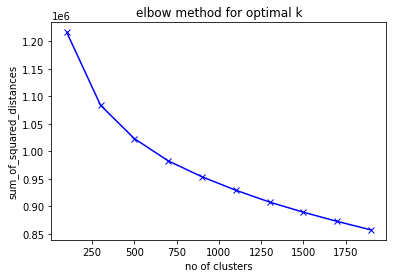

In [14]:
K = range(100, 1901, 200)
sum_of_squared_distances = []
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(its_ready)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('no of clusters')
plt.ylabel('sum_of_squared_distances')
plt.title("elbow method for optimal k")
plt.show()

<div dir='rtl'>
میتوان دید که تقریبا بعد از 700 کلاستر تغییرات خیلی کم شده... پس ما تعداد کلاستر را 700 در نظر میگیریم و رندوم استیت را صفر قرار میدهیم تا نقاط رندوم اینیشیالایز شده را نگه داریم برای سری های بعد هم مشابه باشن تا برای مقایسه با دقت تر عمل کنیم.
<div dir='rtl'>
البته باید نکات زیر را در نظر بگیریم:
    <div dir='rtl'>
- متود البو همیشه پاسخ گو نیست
        <div dir='rtl'>
- داده هایم ما تقریبا به صورت بلاک باکس بوده ولی  میشد حدس ضد حداقل 100 کلاستر باید داشته باشیم
            <div dir='rtl'>
- برای داده ها در این ابعاد فقط با شناخت دیتاست و حدس و آزمون و خطا باید بهینه ترین کا را پیدا کرد و متود البو مناسب نیست


In [15]:
kmeans = KMeans(n_clusters=700, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(its_ready)

<div dir='rtl'>
حال ستون خوشه را به دیتا ست اصلی اضافه میکنیم

In [16]:
original_df = pd.read_csv("random_sample_astan.csv")
original_df = original_df.dropna()
original_df['خوشه'] = pred_y
original_df = original_df.sort_values(by=['خوشه'])
original_df

,Unnamed: 0,متن پيام,پاسخ,تاريخ دريافت,زمان دريافت,خوشه
29152,167237,سلام دختری هستم 32 ساله نماز غذا دارم .میتونم ...,سلام اگر وظیفه اش ایستاده خواندن نماز است بای...,1400/03/17,00:18,0
41551,177430,باسلام من به علت کاروخستگی زیادنمازمونشسته میخ...,سلام و تبریک انسان تا میتواند باید نماز را ایس...,1399/08/13,15:35,0
27778,465544,سلام کسی که کمردرد شدید داشته باشد نماز را نشس...,سلام و تسلیت اگر قادر بر ایستادن حتی با تکیه ب...,1399/06/28,20:09,0
27806,366783,سلام.من هم آرتروززانودارم هم دیسک گردن،واسه نم...,سلام و تبریک ایام در مورد سوال نشسته خواندن نم...,1399/11/14,21:30,0
23478,31753,سلام نمازهای مستحبی رومیشه نشسته خواند رهبری,سلام تبریک بله، نماز مستحبی را میتوان به صورت...,1400/02/23,19:15,0
...,...,...,...,...,...,...
30926,265777,سلام. پسرم یک سال و نه ماه داره. شیر میخوره. ر...,سلام اگر انسان یقین یا اطمینان داشته باشد که ...,1400/01/27,12:00,699
20744,329855,با سلام همسر من معده ضعیفی دارن اوایل ازدواجون...,سلام اگر اطمینان داشته باشد که روزه برایش ضرر...,1400/01/24,15:07,699
22693,247713,سلام وقت بخیر معیار اینکه روزه برای فردی مضر ...,سلام ملاک تشخیص خود شما است در صورتیکه یقین یا...,1400/02/03,17:51,699
25609,195906,سلام به دلیل یبوست نتوانستم روزه امسال را بگی...,سلام اگر اطمینان داشته باشد که روزه برایش ضرر...,1399/07/28,04:02,699


<div dir='rtl'>
میبینیم که نسبتا خوب خوشه بندی انجام شده...
    <div dir='rtl'>
مثلا
        <div dir='rtl'>
خوشه اول راجب نماز و خوشه آخر راجب معده درد و یبوست است، اما بعضی جاها هم اشتباه کرده در خوشه بندی

<div dir='rtl' id="intro"><h2 id="clustering">تحلیل داده با استفاده از KMeans + TF-IDF  </h2><hr></div>
<br>
<div dir='rtl'>
تقریبا مشابه قسمت قبل پیش میریم و تنها قسمت وکتورایز کردن تفاوت دارد.

In [17]:
# load the data set
original_df_tfidf = pd.read_csv("random_sample_astan.csv")
# make a copy of original data frame
original_df_tfidf['متن و پاسخ'] = original_df_tfidf['متن پيام'] + ' ' + original_df_tfidf['پاسخ']
copy_df_tfidf = original_df_tfidf.drop(columns=['Unnamed: 0', 'تاريخ دريافت', 'زمان دريافت', 'متن پيام', 'پاسخ'])
# in case if there are any nan in df :)
copy_df_tfidf = copy_df_tfidf.dropna()
# open stop words file
files = open("persian.txt", encoding="utf8")
stop_words_tfidf = [x.strip() for x in files.readlines()]
# clean up datas
QaA_tfidf = []
stemmer = Stemmer()
normalizer = Normalizer()
for i in copy_df_tfidf.index:
    words = word_tokenize(normalizer.normalize(copy_df_tfidf.loc[i]['متن و پاسخ']))
    st = ""
    for j in words:
        if (j not in stop_words_tfidf) &  (not re.search('[a-zA-Z_ء]', j)):
            st += f" { stemmer.stem(j)}"
    QaA_tfidf.append(st)

<div dir='rtl'>
تا این جای کار که همچیز تکرار بوده... حال برای استفاده از متود tfidf از کتابخوانه اسکی لرن استفاده میکنیم.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
vectorize_df_tfidf = cv.fit_transform(QaA_tfidf)

<div dir='rtl'>
برای بهتر کار کردن با داده های وکتورایز شده آن را تبدیل به دیتا فریم میکنیم

In [19]:
vectorize_df_tfidf = pd.DataFrame(vectorize_df_tfidf.toarray(), columns = cv.get_feature_names_out())
vectorize_df_tfidf.shape

(46578, 62466)

<div dir='rtl'>
میبینیم که 62465 کلمه یونیک(فیچر) داریم که میتوان گف تعداد زیادی از آنها غلط املایی هستند. پس آنهایی که بیشترین مقدار تکرار را دارند جدا میکنیم.
    <div dir='rtl'>
برای این کار ابتدا باید جمع هر ستون را پیدا کنیم

In [20]:
sum_column_tfidf = vectorize_df_tfidf.sum(axis=0)
sum_column_tfidf = sum_column_tfidf.to_frame()
sum_column_tfidf = sum_column_tfidf.sort_values(by=[0])
sum_column_tfidf

,0
رظا,0.051482
عوکلان,0.051482
جزاز,0.051482
شاهچراغ,0.051482
حمزة,0.051482
...,...
خامنه,1088.546417
سوال,1106.774530
روزه,1404.831423
غسل,1492.731041


<div dir='rtl'>
اکنون چون میخواهیم tfidf را با bof مقایسه کنیم، مانند قبل، 1750 تا کلمه پر تکرار را استخراج میکنیم و آن را تبدیل به نامپای اری میکنیم.

In [21]:
# choose most repeated words
most_repeated_tfidf = sum_column_tfidf.index.values[-1750:]
# get subset of original df
selected_vectorize_df_tfidf = vectorize_df_tfidf[most_repeated_tfidf]
# convert it to numpy array
its_ready_tfidf = selected_vectorize_df_tfidf.iloc[:].values

<div dir='rtl'>
حال چون میخواهیم با BOW مقایسه کنیم، تعداد کلاستر را مثل قبل 700 و رندم استیت را 0 در نظر میگیریم تا مقایسه عادلانه باشد...

In [22]:
kmeans = KMeans(n_clusters=700, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y_tfidf = kmeans.fit_predict(its_ready_tfidf)

<div dir='rtl'>
حال دیتا فریم را با توجه به دسته بندی مرتب کرده و نشان میدهیم.

In [23]:
original_df_tfidf = pd.read_csv("random_sample_astan.csv")
original_df_tfidf = original_df_tfidf.dropna()
original_df_tfidf['خوشه'] = pred_y_tfidf
original_df_tfidf = original_df_tfidf.sort_values(by=['خوشه'])
original_df_tfidf

,Unnamed: 0,متن پيام,پاسخ,تاريخ دريافت,زمان دريافت,خوشه
16589,341540,سلام آیت الله سیستانی اگه هنگام رمان خواندن (م...,سلام و تسلیت رطوبتی که زنان در موقع شهوت احساس...,1399/06/23,15:49,0
21278,97486,علایم ارضا شدن زن چیست؟همه موارد را باید باهم ...,سلام رطوبتی که زنان در موقع ملاعبه یا تصوّرات ...,1400/03/19,00:52,0
14559,377420,سلام اگر خانومی در خواب صحنه هایی از بودن در ک...,سلام و تبریک رطوبتی که زنان در موقع ملاعبه ی...,1399/12/27,10:42,0
46391,223576,من خانم هستم.. ومرجع تقلیدم آقای سیستانی هستن,سلام رطوبتی که زنان در موقع تصوّرات شهوت‌انگیز...,1399/11/23,09:51,0
44432,450124,باسلام، در چہ صورت آب خارج شدہ از زن نجس میباش...,سلام و تبریک اگر رطوبت زیادی از زن خارج شده، ب...,1400/01/08,23:26,0
...,...,...,...,...,...,...
16779,137096,باسلام انواع استحاضه قلیله متوسطه و کثیره را ل...,سلام استحاضه سه قسم است: قلیله و متوسطه و کثیر...,1399/12/18,06:52,699
41547,445623,سلام و تسلیت میشه 3نوع استحاضه وحکمشونوبگین چی...,سلام و تسلیت استحاضه قلیله آن است که هرگاه زن،...,1399/06/16,14:36,699
30648,803,خون استحاضه را توضیح دهید,سلام و تسلیت استحاضه قلیله آن است که خون، پنبه...,1399/07/14,16:34,699
2738,195220,سلام.مقدارخون خارج شده برای غسل استحاظه کم ومت...,سلام استحاضه سه قسم است: قلیله و متوسطه و کثیر...,1399/08/09,07:41,699


<div dir='rtl'>
میبینیم که دستبه بندی با tfidf خیلی بهتر انجام شده و صرفا با توجه به تکرار کلمات دسته بندی را انجام نداده، بلکه به معنا کلمات هم اهمیت داده.
<div dir='rtl'>
مثلا دسته اول رطوبت خارج شده از زن هست و دسته آخر هم راجل استحاضه ولی برای مقایسه بهتر squared_distance  را هم به دست می آوریم.

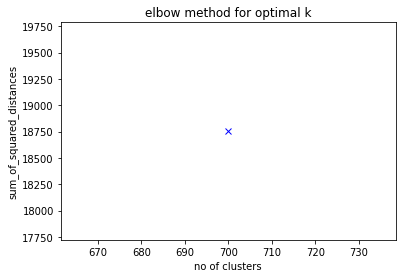

In [24]:
K = range(700, 701)
sum_of_squared_distances = []
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(its_ready_tfidf)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('no of clusters')
plt.ylabel('sum_of_squared_distances')
plt.title("elbow method for optimal k")
plt.show()

<div dir='rtl'>
حتی میبینیم که tifid نسبت به bow مجموع squared_distance خیلی کمتری دارد!
<div dir='rtl'>
-  bow در 700 کلاستر == 1,000,000
<div dir='rtl'>
-  tfidf در 700 کلاستر == 18,750 

<div dir='rtl' id="intro"><h2 id="clustering">تحلیل داده با استفاده از KMeans + fasttext  </h2><hr></div>
<br>
<div dir='rtl'>
طبق معمول داده را پاکسازی میکنیم...
    <div dir='rtl'>
- نکته: برای فست تکست مانند روش های قبل از normalizer استفاده میکنیم اما از stemer استفاده نمیکنیم زیرا خود فست تسکت این قسمت را هندل میکند و کلمات مشابه را حتی اگه حروفشون فرق کنه تشخیص میدهد

In [25]:
# load the data set
original_df_fasttext = pd.read_csv("random_sample_astan.csv")
# make a copy of original data frame
original_df_fasttext['متن و پاسخ'] = original_df_fasttext['متن پيام'] + ' ' + original_df_fasttext['پاسخ']
copy_df_fasttext = original_df_fasttext.drop(columns=['Unnamed: 0', 'تاريخ دريافت', 'زمان دريافت', 'متن پيام', 'پاسخ'])
# in case if there are any nan in df :)
copy_df_fasttext = copy_df_fasttext.dropna()
# open stop words file
files = open("persian.txt", encoding="utf8")
stop_words_fasttext = [x.strip() for x in files.readlines()]
# clean up datas
QaA_fasttext = []
normalizer = Normalizer()
for i in copy_df_fasttext.index:
    words = word_tokenize(normalizer.normalize(copy_df_fasttext.loc[i]['متن و پاسخ']))
    st = ""
    for j in words:
        if (j not in stop_words_fasttext) &  (not re.search('[a-zA-Z_ء]', j)):
            st += f" { j}"
    QaA_fasttext.append(st)

<div dir='rtl'>
اکنون کتباخانه فست تکست را اینپورت میکنیم و مدلی که از وبسایت فست تکست دانلود کردیم را لود میکنیم.

In [26]:
import fasttext
import fasttext.util
ft = fasttext.load_model('cc.fa.300.bin')

<div dir='rtl'>
حال با استفاده از مدل لود شده جمله ها را به وکتور تبدیل میکنیم و سپس آن را به نامپای ارری تبدیل میکنیم 

In [27]:
for i in range(len(QaA_fasttext)):
    QaA_fasttext[i] = ft.get_sentence_vector(QaA_fasttext[i])
QaA_fasttext = np.array(QaA_fasttext)
QaA_fasttext.shape

(46578, 300)

<div dir='rtl'>
میبینیم که فست تسکس هر جمله رو به یک وکتور با طول 300 تبدیل کرده... حال تنها کافیست متود کا مینز را پیاده کنیم.
<div dir='rtl'>
برای اینکه مقایسه با روش های قبلی(bow and tfidf) عادلانه باشد، تعداد کلاستر ها را مانند قبل 700 و رندوم استیت را 0 در نظر میگیریم

In [28]:
kmeans = KMeans(n_clusters=700, init='k-means++', max_iter=500, n_init=10,random_state=0)
pred_y_fasttext = kmeans.fit_predict(QaA_fasttext)
original_df_fasttext = original_df_fasttext.dropna()
original_df_fasttext['خوشه'] = pred_y_fasttext
original_df_fasttext = original_df_fasttext.sort_values(by=['خوشه'])
original_df_fasttext

,Unnamed: 0,متن پيام,پاسخ,تاريخ دريافت,زمان دريافت,متن و پاسخ,خوشه
43554,198530,سلام،تقبل الله آمپول تقویتی روزه رو باطل میکنه...,سلام احتیاط واجب آن است که روزه دار از آمپول ه...,1400/01/25,10:57,سلام،تقبل الله آمپول تقویتی روزه رو باطل میکنه...,0
2167,404481,سلام طاعات قبول :زدنه آمپول ویتامین برا کم خون...,سلام اگر تزریق آمپول غذایی یا تقویتی بین روز ا...,1400/01/29,00:17,سلام طاعات قبول :زدنه آمپول ویتامین برا کم خون...,0
11151,338634,سلام من دوتا امپول زدم یکی بتامتازون دومی مال...,سلام احتیاط واجب آن است که روزه دار از آمپول‌...,1400/02/02,18:30,سلام من دوتا امپول زدم یکی بتامتازون دومی مال...,0
27536,80014,سلام حکم زدن امپول ضد بارداری در ماه رمضان چیس...,سلام آمپول بی‌حس‌کننده و آمپول دارویی که درعض...,1400/01/31,08:04,سلام حکم زدن امپول ضد بارداری در ماه رمضان چیس...,0
38110,352761,با عرض سلام و خسته نباشید آیا تزریق عضلانی در...,سلام احتیاط واجب آن است که روزه دار از آمپول‌ه...,1400/01/24,13:02,با عرض سلام و خسته نباشید آیا تزریق عضلانی در...,0
...,...,...,...,...,...,...,...
22154,5044,سلام آیا اگر چهل روز زیارت عاشورا را با صدبارل...,سلام خواندن زیارت عاشورا بسیار خوب است و به ام...,1400/03/08,05:56,سلام آیا اگر چهل روز زیارت عاشورا را با صدبارل...,699
6433,49386,سلام مگر روز دوشنبه روز زیارتی اباعبدالله نیست...,سلام در روایتی از امام هادی علیه السلام ایام ه...,1400/05/03,09:15,سلام مگر روز دوشنبه روز زیارتی اباعبدالله نیست...,699
31930,415054,رهبرمعظم,سلام برای هر بار زیارت حرم امام رضا علیه السلا...,1400/01/03,18:15,رهبرمعظم سلام برای هر بار زیارت حرم امام رضا ع...,699
7856,316956,سلام خواندن زیارت عاشورا به نیابت از امام زما...,سلام خواندن زیارت عاشورا به نیابت از امام زمان...,1399/08/28,12:53,سلام خواندن زیارت عاشورا به نیابت از امام زما...,699


<div dir='rtl'>
میبینیم که در مثال های قابل مشاهده خوشه بندی به خوبی انجام شده و اصلا مشکلی وجود ندارد
<div dir='rtl'>
مثلا دسته اول راجب تزریقات و دسته آخر هم راجب عاشورا است. برای مقایسه بهتر، squared_distance این روش را هم حساب میکنیم

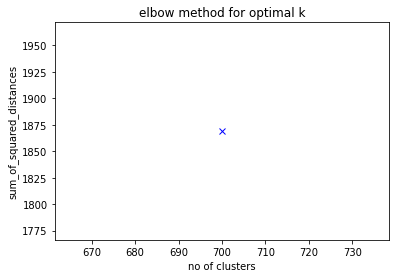

In [29]:
K = range(700, 701)
sum_of_squared_distances = []
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(QaA_fasttext)
    sum_of_squared_distances.append(km.inertia_)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('no of clusters')
plt.ylabel('sum_of_squared_distances')
plt.title("elbow method for optimal k")
plt.show()

<div dir='rtl'>
میبینیم که squared_distance فست تکست از هر دو روش قبلی به شدت کمتر است پس قطعا روش خیلی بهتری نسبت به روش های قبلی است.

<div dir='rtl' id="intro"><h2 id="clustering">جمع بندی  </h2><hr></div>
<br>
<div dir='rtl'>
با توجه به تحلیل هایی که بالا انجام شد و یکسان بودن تعداد داده ها و کلاستر ها در هر سه روش و یکسان بودن نقاط ابتدایی در هر داده، میتوان گفت روش fasttext از هر دو روش bow و tf-idf عملکرد و نتیجه بهتری داشته.
<div dir='rtl'>
مقایسه squared_distance هر سه روش هم همین را بازگو میکند که fasttext بهترین عملکرد را دار زیرا دارای کمترین مقدار squared_distance است.
<div dir='rtl'>
- squared_distance در روش bow == 1,000,000
<div dir='rtl'>
- squared_distance در روش tf-idf == 18,500
<div dir='rtl'>
- squared_distance در روش fasttext == 1,800